In [15]:
# Import packages
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import seaborn as sns
from scipy.stats import norm
from statsmodels.distributions.empirical_distribution import ECDF

# 1. Download the Microsoft daily price from Jan 2, 2022 to Dec 30, 2024 from Yahoo Finance, and perform the following data analysis:

In [16]:
# Download MSFT stock data from yfinance
data = yf.download('MSFT', start = '2022-01-02', end = '2024-12-30', interval = '1d', 
                   auto_adjust = False)['Adj Close']
data.head()

[*********************100%***********************]  1 of 1 completed


Ticker,MSFT
Date,
2022-01-03,324.504578
2022-01-04,318.940308
2022-01-05,306.696838
2022-01-06,304.273315
2022-01-07,304.428436


## (a) Find the sample mean and sample variance of the daily log return (in percentage).

In [17]:
# Log Returns
log_returns = np.log(data / data.shift(1)) * 100

# Drop na's
log_returns = log_returns.dropna()
log_returns.describe()

Ticker,MSFT
count,750.000000
mean,0.036965
std,1.738621
min,-8.029530
25%,-0.853953
50%,0.087479
75%,1.060568
max,7.905887


In [18]:
# Calculate sample variance
log_returns['MSFT'].std()**2

3.0228012494938126

The sample mean of the daily log returns is about 0.037% and the sample variance of the daily log return is about 3.023.

## (b) Estimate the CDF of the daily log return using ECDF. Plot the ECDF along with the normal CDF with mean and variance estimated in part (a). Explain your Öndings.

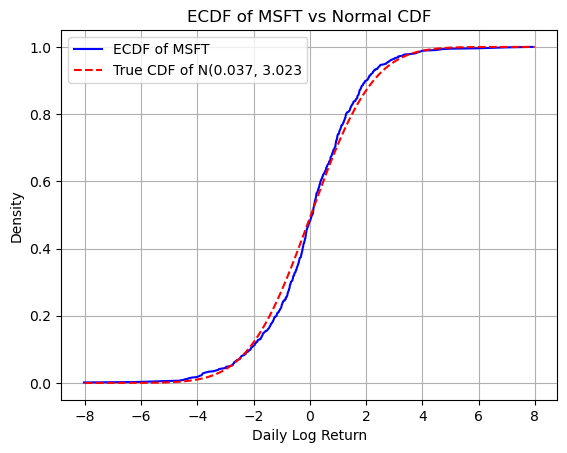

In [19]:
# ECDF of Microsoft daily log returns
result = ECDF(log_returns['MSFT'])

x = np.linspace(-8, 8, 1000)

# Plot that ECDF of MSFT an a normal CDF
plt.plot(result.x, result.y, color = 'blue', label = 'ECDF of MSFT') # ECDF of MSFT returns
plt.plot(x, norm.cdf(x, loc = log_returns.mean(), scale = log_returns.std()), color = 'red', 
         label = 'True CDF of N(0.037, 3.023', linestyle = 'dashed') # Normal CDF
plt.grid()
plt.legend()
plt.xlabel('Daily Log Return')
plt.ylabel('Density')
plt.title('ECDF of MSFT vs Normal CDF')
plt.show()

## (c) Estimate the PDF of the daily log return using kernel estimation. Plot the kernel density estimator along with the normal PDF with mean and variance estimated in part (a). Explain your Findings.

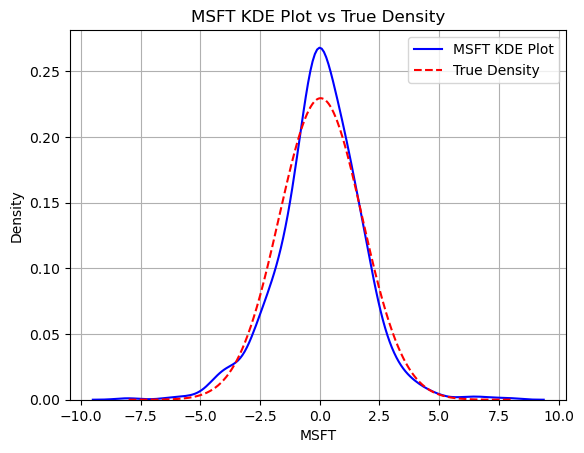

In [20]:
# Plot KDE of MSFT
sns.kdeplot(log_returns['MSFT'].dropna(), bw_method='silverman', label = 'MSFT KDE Plot', color = 'blue')
plt.plot(x,norm.pdf(x, loc = log_returns.mean(), scale = log_returns.std()), label = 'True Density', 
         color = 'red', linestyle = 'dashed')
plt.grid()
plt.legend()
plt.title('MSFT KDE Plot vs True Density')
plt.show()

The KDE plot for Microsoft log returns appears to have a higher density around the mean causing a higher peak, and heavier tails compared to the normal PDF with the same mean and variance.

## (d) Conduct the quantile v.s. quantile plot of the log return against the normal distribution. Explain your Findings. Are the new Findings consistent with those in parts (b) and (c)?

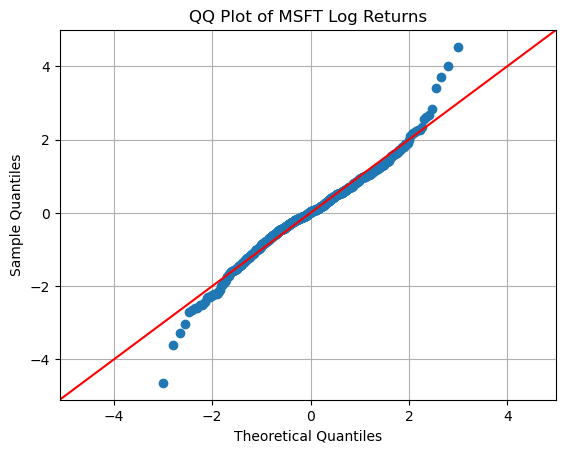

In [21]:
# Standardize returns
standardized_returns = (log_returns['MSFT'] - log_returns['MSFT'].mean()) / log_returns['MSFT'].std()

sm.qqplot(standardized_returns, line='45')
plt.title('QQ Plot of MSFT Log Returns')
plt.grid()
plt.show()

The QQ plot shows that the log returns of MSFT are close to normally distributed around the mean, but deviate from normality at the tails. This is consistent with findings from part (b) and (c), although it may be difficult to see what is happening at the tails.

## (e) Calculate the sample skewness and the sample kurtosis. Test the null hypothesis that the skewness is zero, and the hypothesis that the kurtosis is less than or equal to 3. Are the estimators of skewness and kurtosis consistent with the normal assumption on the log return?

In [22]:
kurt = stats.kurtosis(log_returns['MSFT'], fisher=False) # Calculate kurtosis
skew = stats.skew(log_returns['MSFT']) # Calculate skewness

print('Kurtosis =', kurt)
print('Skewness =', skew)

Kurtosis = 4.887449897628351
Skewness = -0.09651597234003265


In [23]:
T = len(log_returns['MSFT'])

# t-statistics
skew_t_stat = skew / np.sqrt(6/T)
kurt_t_stat = (kurt - 3) / np.sqrt(24/T)

# Test for skewness
skew_p_value = 2 * (1-stats.t.cdf(abs(skew_t_stat), df=T-1))
if skew_p_value < 0.05:
    print('Reject null hypothesis, conclude the skewness is significantly different from 0.')
else:
    print('Fail to reject null hypothesis that skewness is significantly different from 0.')

# Test for kurtosis
kurt_p_value = 1 - stats.t.cdf(kurt_t_stat, df=T-1)
if kurt_p_value < 0.05:
    print('Reject null hypothesis, conclude the kurtosis is greater than 3.')
else:
    print('Fail to reject null hypothesis that kurtosis is significantly different from 3.')

Fail to reject null hypothesis that skewness is significantly different from 0.
Reject null hypothesis, conclude the kurtosis is greater than 3.


The skewness estimator is consistent with the normal assumtption on the log returns of MSFT, but the kurtosis estimator is not.

## (f) Perform the Jarque-Bera Test on the log return and explain the test result.

In [24]:
stats.jarque_bera(log_returns['MSFT'])

SignificanceResult(statistic=112.49151399138255, pvalue=3.7391949309846818e-25)

The Jarque Bera test produces a p-value less than 0.05, meaning we reject the null hypothesis that the log returns of MSFT are normally distributed.

## (g) Now assume that the log return are i.i.d. with a Student-t distribution $t_v(μ, λ)$. Find the maximum likelihood estimators and the standard errors of the unknown parameters $μ$, $λ$ and $v$. Find the 95% asymptotic confidence interval for $v$. Test the null hypothesis $H_0: v >= 10$. Explain the test result.

In [25]:
# Estimate parameters
v_hat, mu_hat, lambda_hat = stats.t.fit(log_returns['MSFT'])

# Bootsrapping
n = len(log_returns)
nboot = 1000
boot_samples = np.zeros((nboot, 3))

for i in range(nboot):
    sample = np.random.choice(log_returns['MSFT'], replace=True, size=n) # Sample data with replacement
    v_b, mu_b, lambda_b = stats.t.fit(sample) # Estimate parameters from sample
    boot_samples[i] = [v_b, mu_b, lambda_b] # Create list of sample parameters

se_v, se_mu, se_lambda = boot_samples.std(axis=0) # Standard error of each parameter

In [26]:
# 95% donfidence intervals
v_CI = [v_hat - 1.96*se_v, v_hat + 1.96*se_v]
mu_CI = [mu_hat - 1.96*se_mu, mu_hat + 1.96*se_mu]
lambda_CI = [lambda_hat - 1.96*se_lambda, lambda_hat + 1.96*se_lambda]

In [27]:
# Create a data table to present parameters and confidence intervals
data = {
    'μ': [mu_hat, se_mu, np.round(mu_CI, 3)],
    'λ': [lambda_hat, se_lambda, np.round(lambda_CI, 3)],
    'ν': [v_hat, se_v, np.round(v_CI, 3)]
}

row_labels = ['MLE', 'SE_bt', 'CI']

df=pd.DataFrame(data, index = row_labels)
print(df)

                    μ              λ               ν
MLE          0.071455       1.385768        5.296588
SE_bt        0.060506        0.06437        1.328879
CI     [-0.047, 0.19]  [1.26, 1.512]  [2.692, 7.901]


The upper bound for the 95% confidence interval for $v$ is less than 10, meaning we reject $H_{0}: v \geq 10$.